In [3]:
# Imports 

import numpy as np
import glob
import csv
import os
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.io import wavfile

plt.style.use('ggplot')

In [2]:
# Functions for accessing length of sequences in WAVE files
def get_recording_lengths(ddir):
    filenames = glob.glob(os.path.join(ddir, '*wav'))
    seq_lengths = np.zeros(len(filenames))
    
    for i, fn in enumerate(filenames):
        _, data = wavfile.read(fn)
        seq_lengths[i] = data.shape[0]
        
    return seq_lengths


def get_training_recording_lengths(training_ddir):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))

    for i, tsd in enumerate(train_sub_ddir):
        if i == 0:
            seq_lengths = get_recording_lengths(tsd)
        else:
            seq_lengths = np.concatenate([seq_lengths, get_recording_lengths(tsd)])
        
    return seq_lengths
    

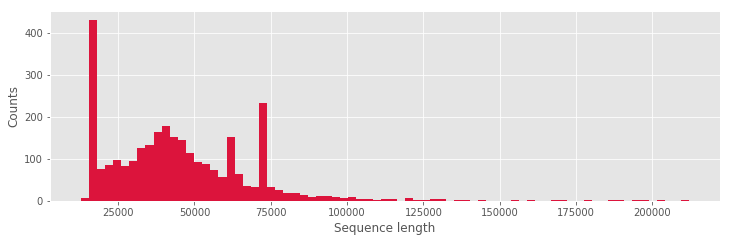

In [3]:
# Plot histogram of sequence lengths
seq_lengths = get_training_recording_lengths('/Volumes/light/deeplearning_proj/data/raw/training/')
plt.xlabel('Sequence length')
plt.ylabel('Counts')
plt.hist(seq_lengths, bins=75, color='crimson')

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()

In [4]:
def rms(data):
    return np.sqrt(np.mean(data ** 2))

In [5]:
# Functions for generating sequences from WAVE files

def gen_sequences(in_ddir, out_ddir):
    
    if not os.path.exists(out_ddir):
        os.mkdir(out_ddir)
        
    if not os.path.exists(os.path.join(out_ddir, 'full')):
        os.makedirs(os.path.join(out_ddir, 'full'))
        
    if not os.path.exists(os.path.join(out_ddir, 'sub')):
        os.makedirs(os.path.join(out_ddir, 'sub'))
        
    filenames = glob.glob(os.path.join(in_ddir, '*wav'))
    for fn in filenames:
        rate, data = wavfile.read(fn)
                
        # Generate subsequences
        subseqs = gen_subsequences(5.0, data, rate, 10000)

        # Save sequence and subsequence arrays
        fn_prefix = fn.split('.')[0].split('/')[-1]
        np.save(os.path.join(out_ddir, 'full', fn_prefix), data)
        for i, s in enumerate(subseqs):
            np.save(os.path.join(out_ddir, 'sub', fn_prefix + '_' + str(i)), s)

    
def gen_subsequences(subseq_size, seq, rate, max_len):

    time = np.arange(len(seq)) / rate
    
    num_windows = (time[-1] // subseq_size).astype(np.int32)

    window_indices = np.zeros(num_windows)
    for n in range(num_windows):
        window_indices[n] = np.where(time < subseq_size * (n + 1))[0][-1]

    subseqs = np.split(seq, window_indices + 1)

    if subseqs[-2].shape[0] - subseqs[-1].shape[0] > 1:
        subseqs = subseqs[:-1]

    for i, s in enumerate(subseqs):
        while s.shape[0] < max_len:
            s = np.insert(s, obj=s.shape[0], values=0)
        subseqs[i] = s
        
    return subseqs

def gen_training_sequences(training_ddir, out_ddir):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
    for tsd in train_sub_ddir:
        gen_sequences(tsd, out_ddir)
    

In [6]:
# Functions for generating spectrograms from WAVE files

def gen_spectrograms(in_ddir, out_ddir, window_size, overlap, rms=False):
    
    if not os.path.exists(out_ddir):
        os.mkdir(out_ddir)
    
    if not rms:
        if not os.path.exists(os.path.join(out_ddir, 'full_ws' + str(window_size))):
            os.makedirs(os.path.join(out_ddir, 'full_ws' + str(window_size)))

        if not os.path.exists(os.path.join(out_ddir, 'sub_ws' + str(window_size))):
            os.makedirs(os.path.join(out_ddir, 'sub_ws' + str(window_size)))
    else:
        if not os.path.exists(os.path.join(out_ddir, 'full_rms_ws' + str(window_size))):
            os.makedirs(os.path.join(out_ddir, 'full_rms_ws' + str(window_size)))

        if not os.path.exists(os.path.join(out_ddir, 'sub_rms_ws' + str(window_size))):
            os.makedirs(os.path.join(out_ddir, 'sub_rms_ws' + str(window_size)))
        
    filenames = glob.glob(os.path.join(in_ddir, '*wav'))
    for fn in filenames:
        rate, data = wavfile.read(fn)
        
        if rms:
            data = data / rms(data)
        
        # Generate spectrogram
        Pxx, freqs, bins, im = plt.specgram(data, NFFT=window_size, Fs=rate, 
                                            mode='psd', noverlap=overlap, scale='linear',
                                            xextent=(0,np.floor(data.shape[0]/rate)))
        
        # Rescale to decibel
        Pxx_dcb = 10 * np.log10(Pxx.clip(1e-10))
#         Pxx_dcb = Pxx
        
        # Generate supspectra
        subspecs = gen_subspecs(5.0, Pxx_dcb, bins, 100)

        # Save spectrogram and subspectra arrays
        fn_prefix = fn.split('.')[0].split('/')[-1]
        if not rms:
            np.save(os.path.join(out_ddir, 'full_ws' + str(window_size), fn_prefix), Pxx_dcb)
        else:
            np.save(os.path.join(out_ddir, 'full_rms_ws' + str(window_size), fn_prefix), Pxx_dcb)
        for i, s in enumerate(subspecs):
            if not rms:
                np.save(os.path.join(out_ddir, 'sub_ws' + str(window_size), fn_prefix + '_' + str(i)), s)
            else:
                np.save(os.path.join(out_ddir, 'sub_rms_ws' + str(window_size), fn_prefix + '_' + str(i)), s)                
        
        # Generate and save spectrogram plot
        #f = plt.gcf()
        #f.set_figwidth(12)
        #f.set_figheight(3.5)
        
        #plt.savefig(os.path.join(out_ddir + '/spect', fn_prefix + '.png'), 
        #            format='png')
        

def gen_training_spectrograms(training_ddir, out_ddir, window_size, overlap):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
    for tsd in train_sub_ddir:
        gen_spectrograms(tsd, out_ddir, window_size, overlap)
        

def gen_subspecs(subspec_size, Pxx, bins, max_len):
    
    num_windows = (bins[-1] // subspec_size).astype(np.int32)

    window_indices = np.zeros(num_windows)
    for n in range(num_windows):
        window_indices[n] = np.where(bins < subspec_size * (n + 1))[0][-1]

    # Partition spectrogram into subspectra
    subspecs = np.split(Pxx, window_indices + 1, axis=1)
    
    # Remove last subpectrum if too small
    if subspecs[-2].shape[1] - subspecs[-1].shape[1] > 1:
        subspecs = subspecs[:-1]

    # Pad subspectra to ensure uniform length
    #max_len = np.max([s.shape[1] for s in subspecs])

    for i, s in enumerate(subspecs):
        while s.shape[1] < max_len:
            s = np.insert(s, obj=s.shape[1], values=0, axis=1)
        subspecs[i] = s
            
    return subspecs
        

# Functions for consolidating REFERENCE files
def gen_training_reference(training_ddir, out_ddir):
    out_reference_file = os.path.join(out_ddir, 'REFERENCE.csv')
    
    with open(out_reference_file, 'w') as write_file:
        writer = csv.writer(write_file, delimiter=',')
        
        train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
        
        for tsd in train_sub_ddir:
            in_reference_file = os.path.join(tsd, 'REFERENCE.csv') 
            
            with open(in_reference_file, 'r') as read_file:
                reader = csv.reader(read_file, delimiter=',')

                for row in reader:
                    writer.writerow(row)
                                    

In [7]:
# Consolidate reference files
gen_training_reference('/Volumes/light/deeplearning_proj/data/raw/training/', 
                       '/Volumes/light/deeplearning_proj/data/spectrogram/training/')

In [12]:
# Generate sequence and subsequences for all training data
gen_training_sequences(training_ddir='data/raw/training/', 
                       out_ddir='data/sequence/training/')

# Generate spectrograms and subspectrograms for validation data
gen_sequences(in_ddir='data/raw/validation/', 
              out_ddir='data/sequence/validation/')

/Users/torod/anaconda2/envs/py35/lib/python3.5/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


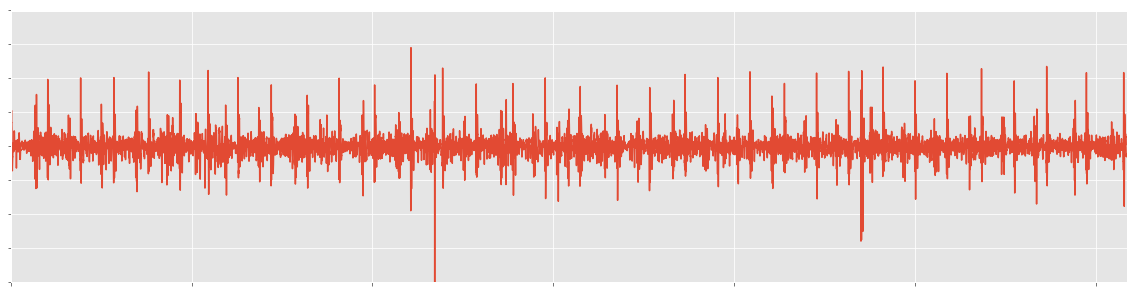

In [7]:
# Plot example sequence

fn = '/Volumes/light/deeplearning_proj/data/sequence/training/full/a0231.npy'

data = np.load(fn)
time = np.arange(data.shape[0]) / 2000
plt.plot(time, data / max(abs(data)))
plt.xlim([0, time[-1]])
# plt.xlabel('Time [sec]', fontsize=20)
plt.ylim(-1.0, 1.0)

ax = plt.gca()
ax.tick_params(axis='both', labelsize=10)

f = plt.gcf()
f.set_figwidth(20.0)
f.set_figheight(5.0)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.show()

In [114]:
#Explore window_size = 300, 500, 1000, overlap = 200, 400, 900)

# Generate spectrograms and subspectrograms for all training data
gen_training_spectrograms(training_ddir='data/raw/training', 
                          out_ddir='data/spectrogram/training',
                          window_size=300,
                          overlap=200)

# Generate spectrograms and subspectrograms for validation data
gen_spectrograms(in_ddir='data/raw/validation', 
                 out_ddir='data/spectrogram/validation',
                 window_size=300,
                 overlap=200)

/Users/torod/anaconda2/envs/py35/lib/python3.5/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


OSError: obtaining file position failed

In [11]:
x=np.load('data/spectrogram/training/sub_ws500/a0058_2.npy')
x.shape

(251, 100)

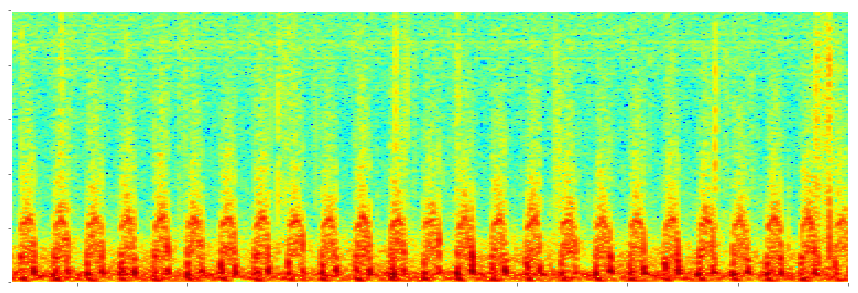

In [106]:
# Plot example spectrogram (Explore NFFT = 300, 500, 1000, noverlap = 200, 400, 900)
def rms(data):
    return np.sqrt(np.mean(data ** 2))

rate, data = wavfile.read('/Volumes/light/deeplearning_proj/data/raw/validation/a0002.wav')

Pxx, freqs, bins, im = plt.specgram(data, NFFT=500, Fs=rate, 
                                    mode='psd', noverlap=400, scale='dB',
                                    xextent=(0, np.floor(data.shape[0]/rate)))

plt.pcolormesh(bins, freqs, 10 * np.log10(Pxx), cmap='jet')
plt.xlim((1.0, np.floor(data.shape[0]/rate)))
# plt.ylabel('Frequency [Hz]', fontsize=20)
# plt.xlabel('Time [Sec]', fontsize=20)

ax = plt.gca()
ax.tick_params(axis='both', labelsize=10)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

f = plt.gcf()
f.set_figwidth(15)
f.set_figheight(5.0)
# plt.colorbar(format='%+2.0f dB')
plt.show()

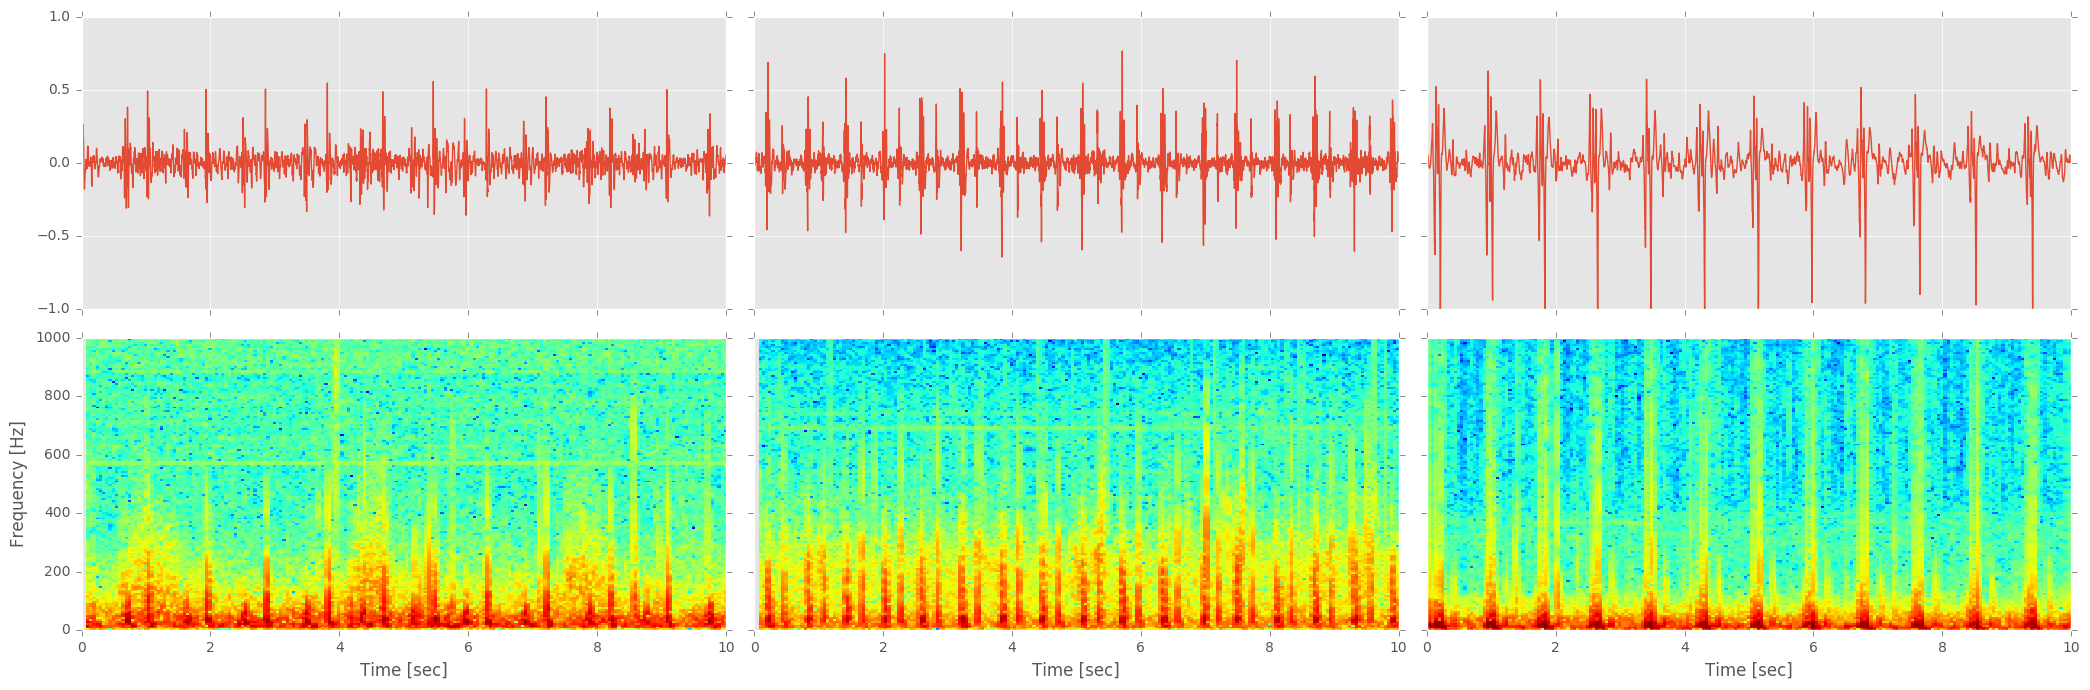

In [21]:
# Comparison of normal and abnormal rhythms

# normal examples
# a0231
# c0011
# d0043

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row')
data_files = ['data/raw/training/training-a/a0231.wav', 
              'data/raw/training/training-c/c0011.wav',
              'data/raw/training/training-d/d0043.wav']

for i, df in enumerate(data_files):
    rate, data = wavfile.read(df)

    Pxx, freqs, bins, im = plt.specgram(data, NFFT=300, Fs=rate, 
                                        mode='psd', noverlap=200, scale='dB',
                                        xextent=(0,np.floor(data.shape[0]/rate)))
    
    axes[1, i].pcolormesh(bins, freqs, 10*np.log10(Pxx))
    axes[0, i].plot(np.arange(len(data))/rate, data/np.max(np.abs(data)))
    
    axes[1, i].set_xlim((0, 10.0))
    axes[0, i].set_xlim((0, 10.0))
    axes[0, i].set_ylim((-1, 1))
    
    axes[1, i].set_xlabel('Time [sec]')
axes[1, 0].set_ylabel('Frequency [Hz]')

f = plt.gcf()
f.set_figwidth(21)
f.set_figheight(7.0)

plt.draw()
plt.tight_layout()
plt.show()
plt.close()


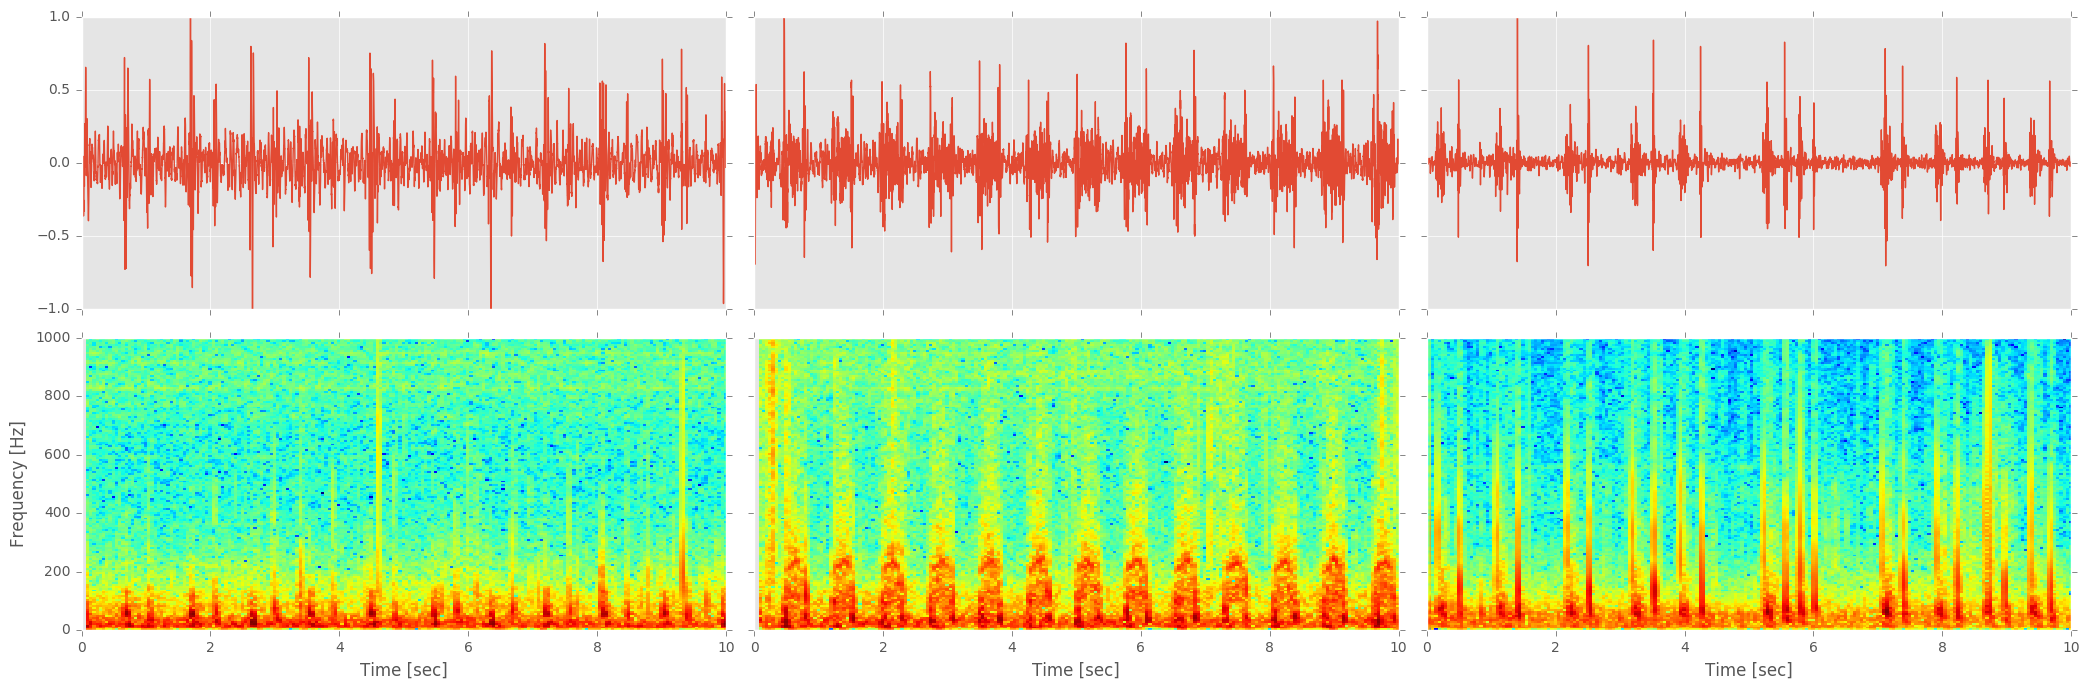

In [32]:
# Comparison of normal and abnormal rhythms

# abnormal examples
# a0400
# c0029
# d0033

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row')
data_files = ['data/raw/training/training-a/a0058.wav', 
              'data/raw/validation/a0002.wav',
              'data/raw/training/training-d/d0033.wav']

for i, df in enumerate(data_files):
    rate, data = wavfile.read(df)

    Pxx, freqs, bins, im = plt.specgram(data, NFFT=300, Fs=rate, 
                                        mode='psd', noverlap=200, scale='dB',
                                        xextent=(0,np.floor(data.shape[0]/rate)))
    
    axes[1, i].pcolormesh(bins, freqs, 10*np.log10(Pxx))
    axes[0, i].plot(np.arange(len(data))/rate, data/np.max(data))
    
    axes[1, i].set_xlim((0, 10.0))
    axes[0, i].set_xlim((0, 10.0))
    axes[0, i].set_ylim((-1, 1))
    
    axes[1, i].set_xlabel('Time [sec]')
axes[1, 0].set_ylabel('Frequency [Hz]')

f = plt.gcf()
f.set_figwidth(21)
f.set_figheight(7.0)

plt.draw()
plt.tight_layout()
plt.show()
plt.close()


In [42]:
# Load data labels
label_dict = {}
with open('data/sequence/REFERENCE.csv', 'r') as label_file:
    reader = csv.reader(label_file, delimiter=',')    
    for i, row in enumerate(reader):
        label_dict[row[0]] = row[1]

# Load data subsequence seperating normal and abnormal sequences
data_filenames = glob.glob(os.path.join('data/sequence/training/sub', '*_0.npy'))

normal_seq = []
abnormal_seq = []
for i, df in enumerate(data_filenames):
    prefix = df.split('/')[-1].split('_0')[0]
    data = np.load(df)
    if label_dict[prefix] == '-1':
        normal_seq.append(data)
    else:
        abnormal_seq.append(data)

normal_seq = np.array(normal_seq, dtype=np.int32)
abnormal_seq = np.array(abnormal_seq, dtype=np.int32)


In [ ]:
# Load data subsequence seperating normal and abnormal sequences
data_filenames = glob.glob(os.path.join('data/sequence/training/sub', '*_0.npy'))

normal_seq_full = []
abnormal_seq_full = []
for i, df in enumerate(data_filenames):
    prefix = df.split('/')[-1].split('_0')[0]
    data = np.load(df)
    if label_dict[prefix] == '-1':
        normal_seq.append(data)
    else:
        abnormal_seq.append(data)

normal_seq = np.array(normal_seq, dtype=np.int32)
abnormal_seq = np.array(abnormal_seq, dtype=np.int32)

In [ ]:
# Cross correlation
x=np.correlate(normal_seq[0, :], normal_seq[0, :], 'full')
print(normal_seq[0,:].shape)
print(x.shape)



In [100]:
# Pearsons Correlation
from scipy.stats import pearsonr

norm_pcorr = np.zeros([normal_seq.shape[0], normal_seq.shape[0]])
for i in range(normal_seq.shape[0]):
    for j in range(normal_seq.`bshape[0]):
        norm_pcorr[i, j] = pearsonr(normal_seq[i, :], normal_seq[j, :])[0]

In [113]:
ab_pcorr = np.zeros([abnormal_seq.shape[0], abnormal_seq.shape[0]])
for i in range(abnormal_seq.shape[0]):
    for j in range(abnormal_seq.shape[0]):
        ab_pcorr[i, j] = pearsonr(abnormal_seq[i, :], abnormal_seq[j, :])[0]

In [108]:
norm_ab_pcorr = np.zeros([normal_seq.shape[0], abnormal_seq.shape[0]])
for i in range(normal_seq.shape[0]):
    for j in range(abnormal_seq.shape[0]):
        norm_ab_pcorr[i, j] = pearsonr(normal_seq[i, :], abnormal_seq[j, :])[0]

In [118]:
print(np.mean(norm_pcorr)/2)
print(np.mean(ab_pcorr)/2)
print(np.mean(norm_ab_pcorr))

print(np.std(norm_pcorr))
print(np.std(ab_pcorr))
print(np.std(norm_ab_pcorr))

0.000223827524696
0.00091657923705
-6.53830585321e-06
0.037712166103
0.0584129807481
0.0329694820834


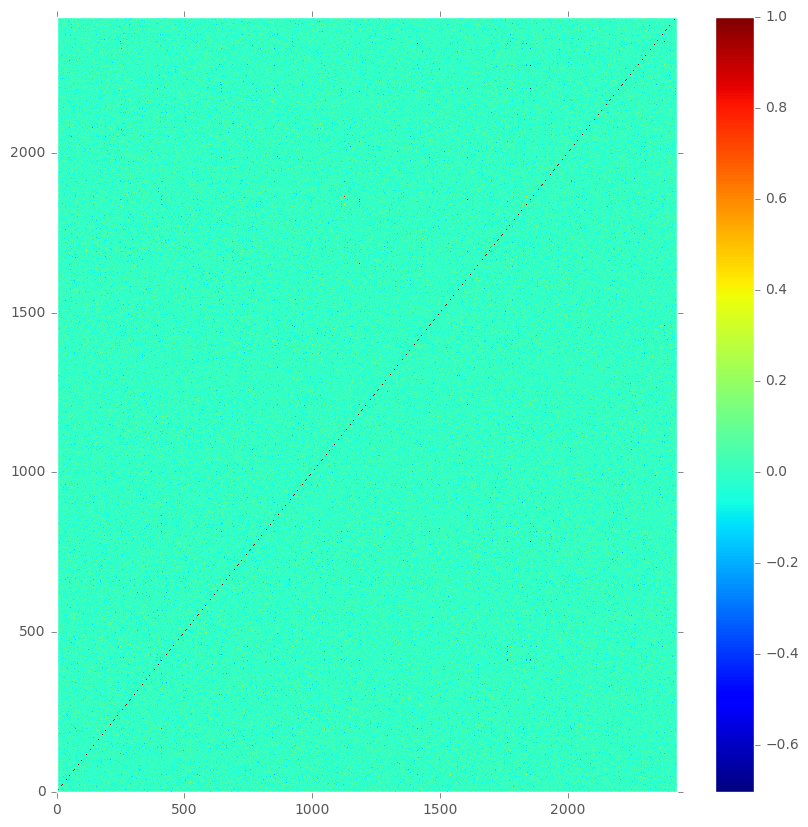

In [104]:
plt.pcolormesh(norm_pcorr, vmin=np.min(norm_pcorr), vmax=np.max(norm_pcorr))
plt.xlim([0, 2425])
plt.ylim([0, 2425])

plt.colorbar()

f = plt.gcf()
f.set_figwidth(10)
f.set_figheight(10)

plt.show()

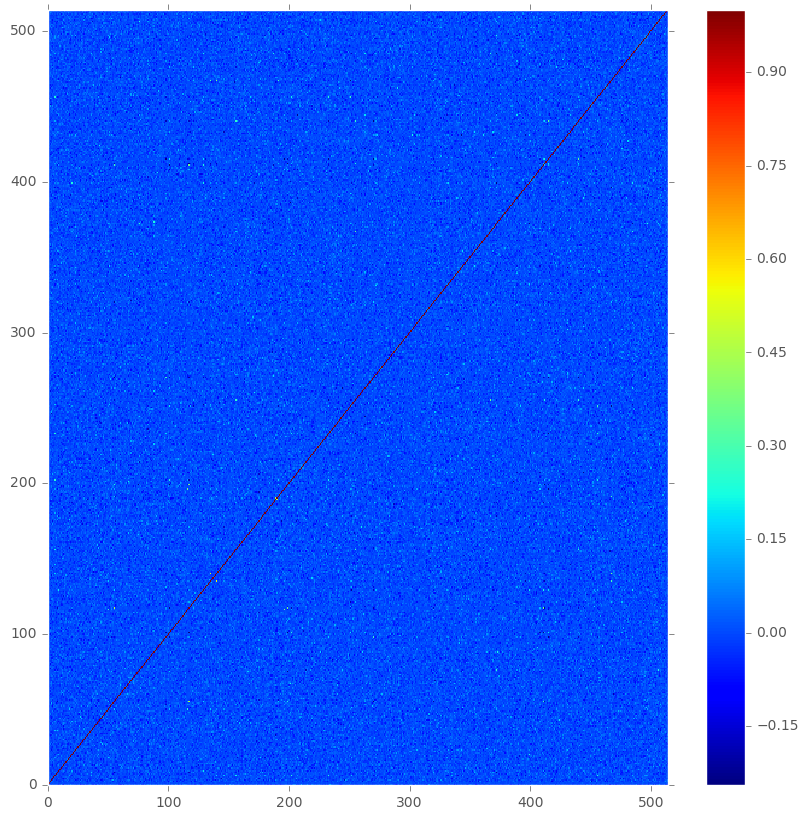

In [106]:
plt.pcolormesh(norm_pcorr, vmin=np.min(ab_pcorr), vmax=np.max(ab_pcorr))
plt.xlim([0, 514])
plt.ylim([0, 514])

plt.colorbar()

f = plt.gcf()
f.set_figwidth(10)
f.set_figheight(10)

plt.show()

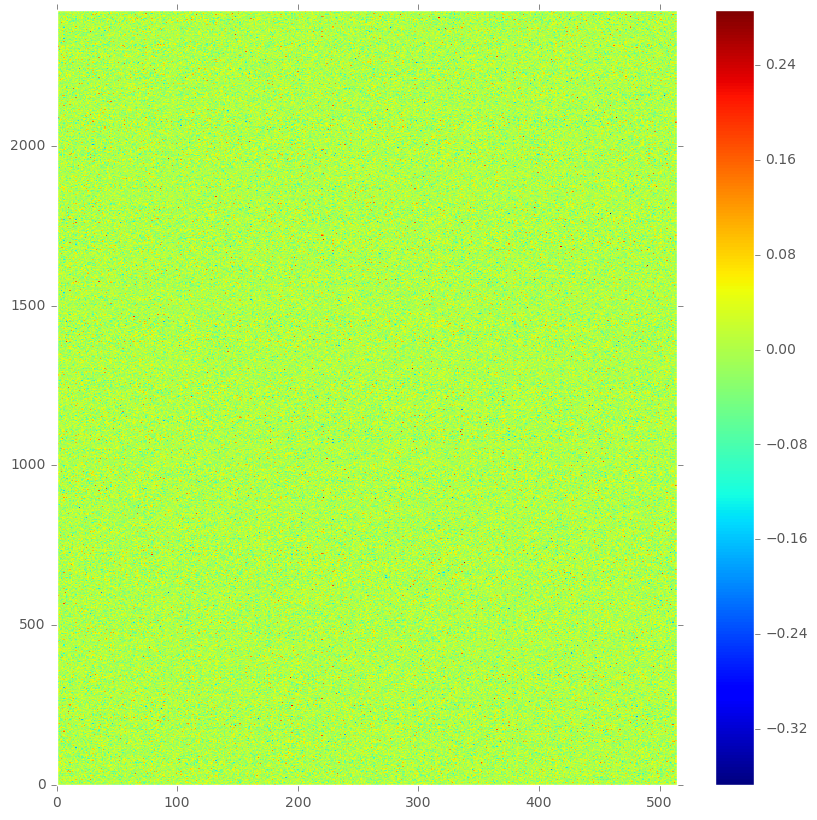

In [110]:
plt.pcolormesh(norm_ab_pcorr, vmin=np.min(norm_ab_pcorr), vmax=np.max(norm_ab_pcorr))
plt.xlim([0, 514])
plt.ylim([0, 2425])

plt.colorbar()

f = plt.gcf()
f.set_figwidth(10)
f.set_figheight(10)

plt.show()

In [60]:
# Define RMSE function
def rmse(sig1_arr, sig2_arr):
    rmse_arr = np.zeros([sig1_arr.shape[0], sig2_arr.shape[0]])
    for i, s in enumerate(sig1_arr):
        error = s[None, :] - sig2_arr
        rmse_arr[i, :] = np.sqrt(np.mean(error ** 2, axis=1))
    
    return rmse_arr

def rmse_vec(sig1_arr, sig2_arr):
    error = sig1_arr[:, None, :] - sig2_arr[None, :, :]
    return np.sqrt(np.mean(error ** 2, axis=2))

# normal_rmse = np.zeros([normal_seq.shape[0], normal_seq.shape[0]])
# for i, s in enumerate(normal_seq):
#     normal_rmse[i, :] = rmse(s, normal_seq)
    
# abnormal_rmse = np.zeros([abnormal_seq.shape[0], abnormal_seq.shape[0]])
# for i, s in enumerate(abnormal_seq):
#     abnormal_rmse[i, :] = rmse(s, abnormal_seq)
    
# normal_rmse = np.zeros([normal_seq.shape[0], normal_seq.shape[0]])
# for i, s in enumerate(normal_seq):
#     normal_rmse[i, :] = rmse(s, abnormal_seq)

ab_rmse = rmse(abnormal_seq, abnormal_seq)
norm_rmse = rmse(normal_seq, normal_seq)


In [86]:
norm_ab_rmse = rmse(normal_seq, abnormal_seq)

In [64]:
np.mean(np.mean(norm_rmse, axis=1))

5619.249952075812

In [65]:
np.mean(np.mean(abnormal_rmse, axis=1))

4158.2480292892797

In [90]:
np.mean(np.mean(norm_ab_rmse, axis=1))

4987.6196041225239

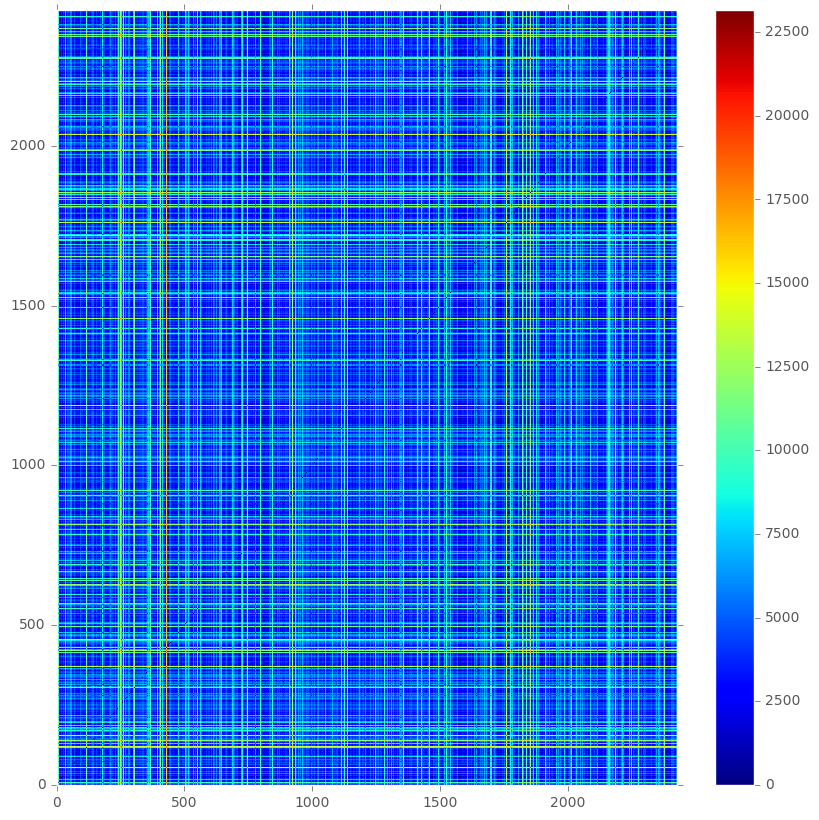

In [68]:
plt.pcolormesh(norm_rmse, vmin=np.min(norm_rmse), vmax=np.max(norm_rmse))
plt.xlim([0,2425])
plt.ylim([0,2425])

plt.colorbar()

f = plt.gcf()
f.set_figwidth(10)
f.set_figheight(10)

plt.show()

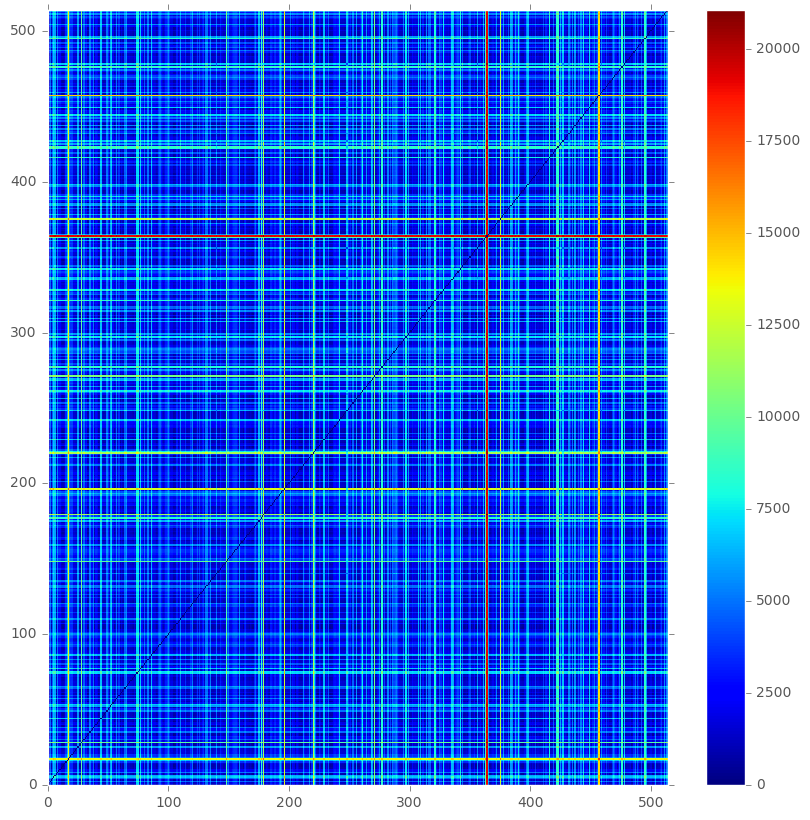

In [69]:
plt.pcolormesh(abnormal_rmse)
plt.xlim([0,514])
plt.ylim([0,514])

plt.colorbar()

f = plt.gcf()
f.set_figwidth(10)
f.set_figheight(10)

plt.show()

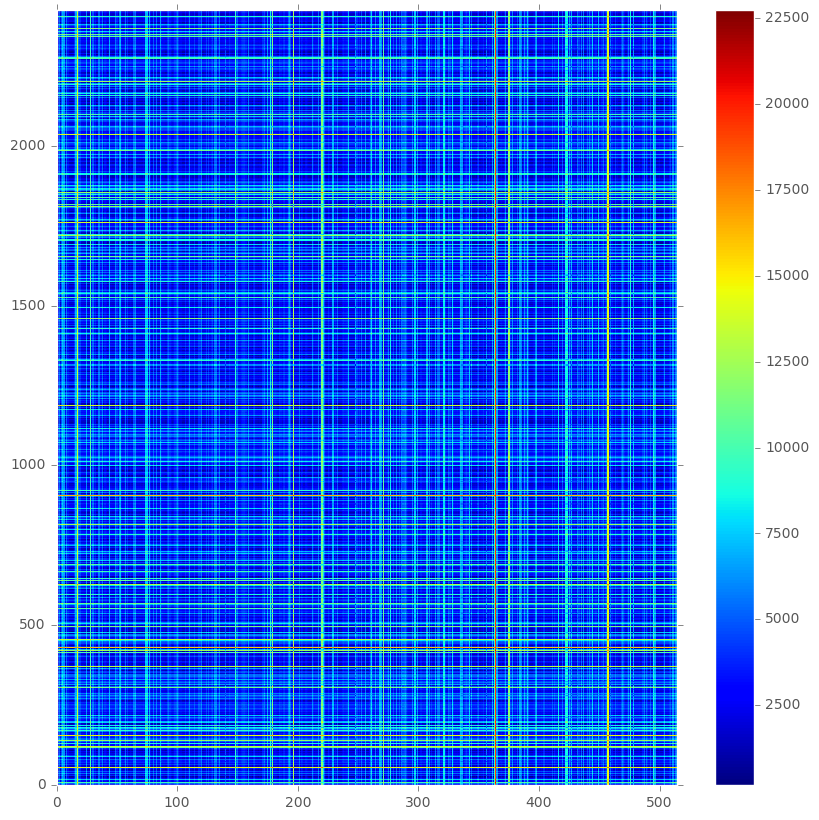

In [89]:
plt.pcolormesh(norm_ab_rmse)
plt.xlim([0,514])
plt.ylim([0,2425])

plt.colorbar()

f = plt.gcf()
f.set_figwidth(10)
f.set_figheight(10)

plt.show()

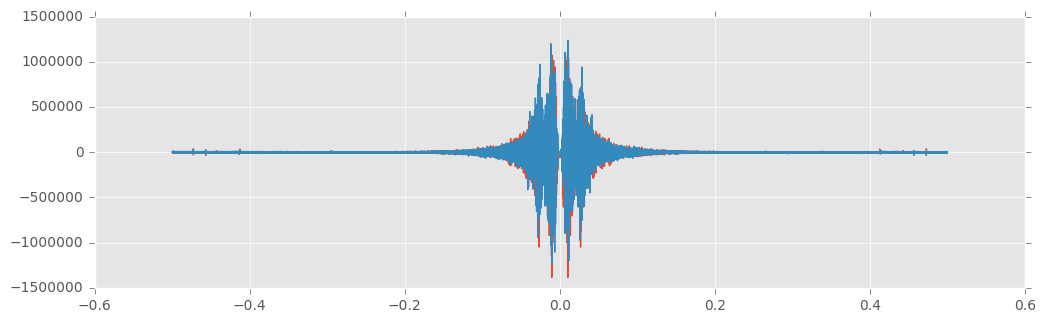

In [174]:
import matplotlib.pyplot as plt
sp = np.fft.fft(signal1)
freq = np.fft.fftfreq(len(signal1))
plt.plot(freq, sp.real, freq, sp.imag)

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()t

[ -1680 -10409 -24090 ..., -24090 -10409  -1680]


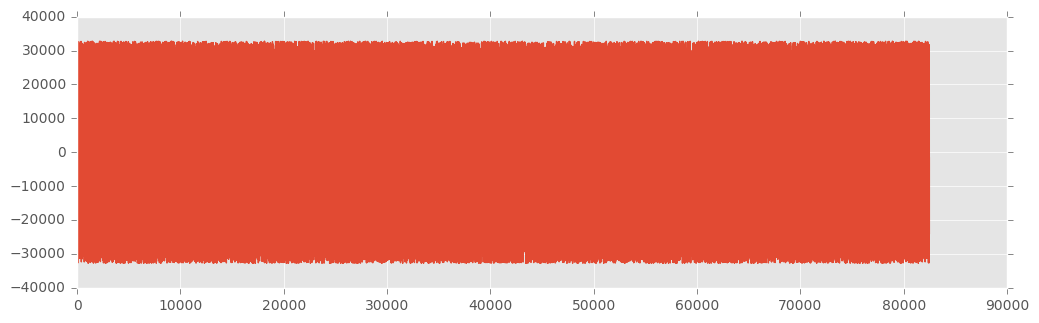

27162


In [164]:
signal1 = np.load('data/sequence/training/full/a0058.npy')
signal2 = np.load('data/sequence/training/full/a0058.npy')
    
corr = np.correlate(signal1, signal2, mode='full')
print(corr)

plt.plot(corr)
# plt.xlim([0, 40])
# plt.xlabel('Time [sec]')

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()

print(np.argmax(np.abs(corr)))


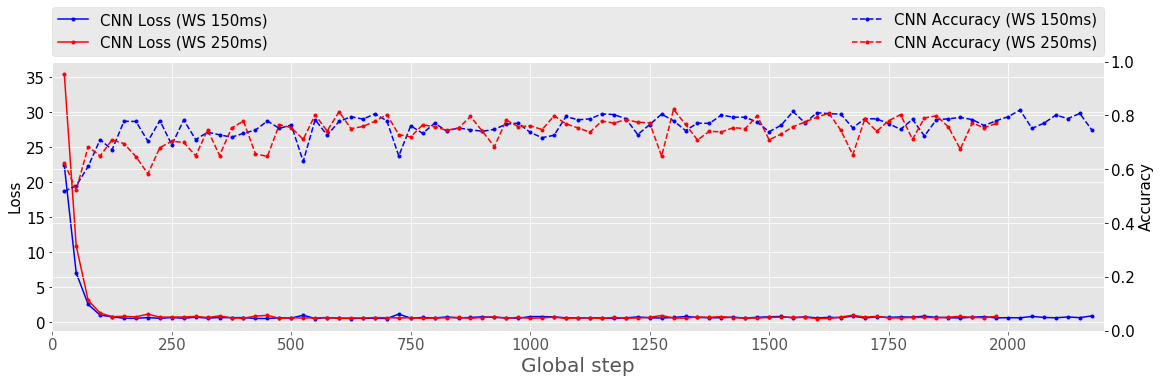

In [131]:
# Plot Loss and Accuracy for CNN

fig, ax1 = plt.subplots()
t = np.arange(25, 2200, 25)
t2 = np.arange(25, 2000, 25)

loss = [22.439217,7.0669703,2.5710793,1.0334258,0.80163318,0.59093833,0.5764097,0.68985748,0.57716787,0.69053936,0.58429646,0.74095279,0.61020923,0.69191992,0.67416656,0.68811512,0.55905503,0.55407834,0.64655584,0.61549163,1.0185009,0.54766411,0.67841405,0.59335154,0.5510419,0.58737457,0.58945489,0.54411113,1.179183,0.60478687,0.69685626,0.62774223,0.77445531,0.63274515,0.70065802,0.78905815,0.71181196,0.65650898,0.5904665,0.82225984,0.83299518,0.78432786,0.64416438,0.62035167,0.65467131,0.62384099,0.55415964,0.6433261,0.77698505,0.64391506,0.62295616,0.69737095,0.8437075,0.70048022,0.65982658,0.65815151,0.73573261,0.60983717,0.72305453,0.79564345,0.84573829,0.63618362,0.79464096,0.6371038,0.71349931,0.67270851,0.88620383,0.62105328,0.79098272,0.71128505,0.77722174,0.75817245,0.88201195,0.71196097,0.65793806,0.62688339,0.73643428,0.81838089,0.63797539,0.67032486,0.64596277,0.85016066,0.70515555,0.6518234,0.77298373,0.6712153,0.9225167]
loss2 = [35.502678,10.899769,3.15027,1.3347958,0.81524277,0.85917085,0.79325974,1.1735036,0.74753356,0.75532633,0.77461153,0.83874822,0.70332456,0.92059708,0.64013004,0.59807318,0.89534253,0.99548489,0.58226466,0.64954579,0.6226331,0.64227241,0.68671483,0.57954794,0.63028353,0.61569905,0.68198961,0.67012882,0.62643653,0.66385388,0.58453631,0.63146138,0.65761542,0.71223283,0.59268004,0.69023818,0.78968883,0.59369284,0.71654743,0.58980012,0.64598918,0.75651199,0.55977654,0.64185095,0.64811885,0.56289446,0.70544755,0.59879577,0.63094461,0.72346526,0.98002094,0.61861825,0.60562795,0.76688617,0.72262448,0.82010007,0.68483233,0.61746073,0.61519265,0.71101362,0.74140251,0.72581363,0.71441674,0.54829001,0.55763495,0.76448107,1.0183197,0.75419235,0.84719312,0.63572091,0.63676161,0.70679682,0.70220447,0.67171198,0.74540436,0.84877801,0.70561957,0.67159933,0.85423088]
CNN_loss, = ax1.plot(t, loss, 'b.-', label='CNN Loss (WS 150ms)')
CNN_loss2, = ax1.plot(t2, loss2, 'r.-', label='CNN Loss (WS 250ms)')
ax1.set_xlabel('Global step', fontsize=20)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Loss', color='k', fontsize=15)
ax1.tick_params('y', colors='k')
ax1.tick_params(axis='both', labelsize=15)

accu = [0.51766783,0.53886926,0.61042404,0.71024734,0.67226148,0.77826858,0.77738518,0.70406359,0.78091872,0.69081271,0.78268552,0.71024734,0.73763251,0.72791517,0.71908128,0.73321557,0.74558306,0.77915192,0.7517668,0.76413429,0.62897527,0.78445232,0.72614843,0.77738518,0.79505301,0.78621906,0.80565369,0.78003532,0.6492933,0.76148409,0.73321557,0.77120143,0.74204946,0.75353354,0.74646646,0.74116606,0.7482332,0.76766783,0.77120143,0.73674911,0.71731448,0.72614843,0.79593641,0.78356892,0.78710246,0.80565369,0.80300355,0.78798586,0.72879857,0.76590109,0.80477029,0.78003532,0.74381626,0.77120143,0.77031803,0.80123675,0.7932862,0.7932862,0.77473497,0.73939931,0.76325089,0.81448764,0.77208483,0.81007069,0.80653709,0.80477029,0.75353354,0.78798586,0.78710246,0.76943463,0.7482332,0.78533566,0.72349823,0.78445232,0.78710246,0.7924028,0.78445232,0.76236749,0.78003532,0.79505301,0.81978798,0.7517668,0.77120143,0.80123675,0.78798586,0.80742049,0.74646646]
accu2 = [0.62367493,0.52296817,0.68374556,0.6492933,0.70936394,0.69522971,0.6466431,0.58303887,0.68021202,0.70406359,0.69964665,0.6501767,0.74646646,0.65106004,0.7526502,0.77915192,0.65724379,0.6475265,0.76590109,0.75441694,0.71113074,0.80212015,0.74204946,0.81360424,0.7508834,0.75883394,0.77826858,0.80300355,0.72879857,0.71996468,0.76501769,0.75795054,0.74469966,0.7526502,0.79593641,0.74116606,0.68374556,0.78268552,0.75795054,0.76148409,0.7473498,0.79858655,0.76855123,0.75353354,0.73763251,0.77915192,0.77120143,0.78445232,0.77473497,0.77208483,0.6484099,0.82243818,0.76678443,0.70848054,0.74116606,0.73851591,0.75441694,0.7508834,0.79858655,0.70936394,0.73056537,0.75795054,0.77561837,0.7932862,0.80830389,0.74469966,0.65371025,0.78533566,0.74116606,0.78003532,0.80300355,0.71113074,0.79063606,0.79858655,0.75706714,0.67491168,0.77208483,0.75353354,0.77031803]
ax2 = ax1.twinx()
CNN_accu, = ax2.plot(t, accu, 'b.--', label='CNN Accuracy (WS 150ms)')
CNN_accu2, = ax2.plot(t2, accu2, 'r.--', label='CNN Accuracy (WS 250ms)')
ax2.set_ylim(0, 1.0)
ax2.set_ylabel('Accuracy', color='k', fontsize=15)
ax2.tick_params('y', colors='k')
ax2.tick_params(axis='both', labelsize=15)

plt.xlim([0, t[-1] + 25])

# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0., handles=[CNN_loss, CNN_accu])

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., 
           handles=[CNN_loss, CNN_loss2, CNN_accu, CNN_accu2],
           fontsize=15)

fig.tight_layout()

f = plt.gcf()
f.set_figwidth(20.0)
f.set_figheight(5.0)

plt.show()


In [46]:
max(accu)

0.81360424

152


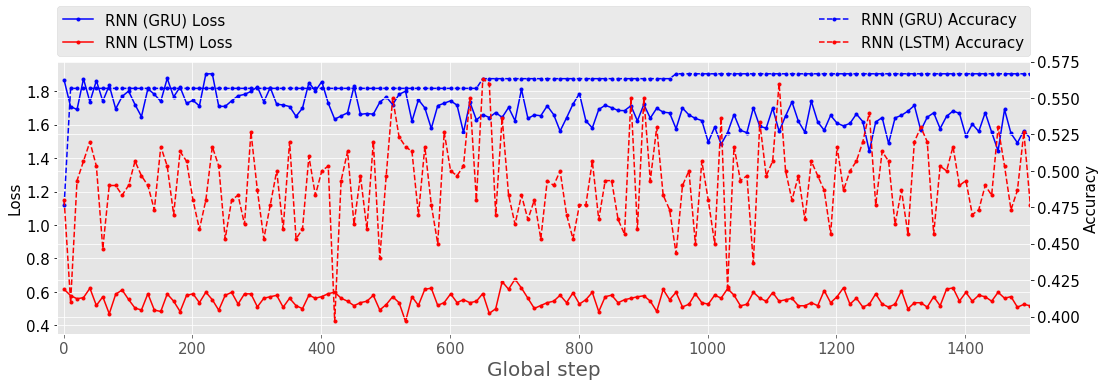

In [129]:
# Plot Loss and Accuracy for RNNs

fig, ax1 = plt.subplots()
t_gru = np.arange(1, 1521, 10)
t_lstm = np.arange(1, 2011, 10)

loss_gru = [1.86424,1.70723,1.68987,1.87335,1.73527,1.86226,1.73928,1.83397,1.69365,1.76774,1.7999,1.71914,1.64718,1.81381,1.7808,1.73838,1.87574,1.76545,1.82376,1.72698,1.74437,1.71127,1.90266,1.90309,1.70897,1.70828,1.74175,1.77153,1.78015,1.79771,1.82554,1.73575,1.82097,1.72116,1.71709,1.7075,1.64889,1.69793,1.85062,1.80035,1.85672,1.72766,1.632,1.65089,1.67029,1.8276,1.66062,1.66594,1.66194,1.73275,1.76577,1.71902,1.78036,1.79907,1.61969,1.74832,1.69923,1.57672,1.71287,1.72716,1.74186,1.71568,1.55301,1.7333,1.62803,1.65916,1.64202,1.67182,1.64238,1.70196,1.62284,1.81025,1.63643,1.65723,1.65249,1.71157,1.65933,1.56122,1.64002,1.72207,1.78443,1.62199,1.57991,1.69022,1.71506,1.70082,1.68395,1.68306,1.71247,1.62186,1.71997,1.63839,1.69733,1.6743,1.66951,1.57502,1.69853,1.65755,1.6366,1.62396,1.49552,1.58469,1.48238,1.55173,1.65988,1.56542,1.55162,1.69995,1.58883,1.57872,1.69827,1.55946,1.65068,1.73477,1.61898,1.55482,1.73979,1.61537,1.56622,1.65479,1.6081,1.59184,1.60691,1.66299,1.61723,1.44002,1.61522,1.64162,1.48714,1.63938,1.65529,1.68027,1.71415,1.56536,1.64405,1.67,1.57608,1.64911,1.68064,1.66698,1.53156,1.60268,1.55887,1.67128,1.55455,1.44316,1.68992,1.54734,1.49088,1.56356,1.51653,1.61191]
loss_lstm = [0.615433,0.578305,0.559405,0.565987,0.622201,0.519135,0.571049,0.469607,0.586134,0.611889,0.555011,0.503543,0.492237,0.589613,0.491667,0.483359,0.588019,0.544926,0.482868,0.579195,0.588918,0.536252,0.598583,0.553648,0.491098,0.580053,0.597359,0.527622,0.588694,0.588625,0.510766,0.562346,0.571466,0.579748,0.508636,0.562505,0.518234,0.500219,0.580576,0.562745,0.572022,0.589612,0.598422,0.562558,0.544757,0.518082,0.535913,0.544739,0.579963,0.492305,0.524369,0.571396,0.535813,0.423925,0.571167,0.519872,0.61627,0.62225,0.519764,0.536296,0.588549,0.536501,0.553609,0.535598,0.544524,0.590503,0.471904,0.499699,0.661441,0.616276,0.676463,0.623406,0.562463,0.50142,0.519013,0.535866,0.544689,0.580416,0.536025,0.594754,0.527888,0.553728,0.59762,0.482418,0.571762,0.580703,0.535614,0.55358,0.562399,0.571119,0.577029,0.545276,0.483946,0.614912,0.553671,0.597693,0.510526,0.526609,0.589364,0.535701,0.526817,0.581084,0.5629,0.6196,0.580863,0.517228,0.526243,0.598182,0.562886,0.544458,0.596378,0.544851,0.553573,0.561467,0.517251,0.517452,0.535768,0.51787,0.608223,0.53562,0.571718,0.625303,0.527102,0.56271,0.50984,0.526149,0.588813,0.527569,0.509532,0.526796,0.607678,0.499249,0.535485,0.535603,0.509383,0.571567,0.517492,0.61687,0.623941,0.545823,0.597425,0.544918,0.5801,0.57133,0.544732,0.598037,0.562645,0.571784,0.508811,0.526007,0.517292,0.516945,0.590324,0.517102,0.607978,0.616094,0.544723,0.588882,0.536039,0.536132,0.598422,0.509996,0.571309,0.518276,0.580904,0.562549,0.544645,0.500892,0.65902,0.579685,0.562313,0.536224,0.561171,0.553762,0.545233,0.571143,0.464939,0.606314,0.562041,0.527931,0.53627,0.562431,0.527342,0.562347,0.587898,0.622611,0.571274,0.57145,0.517602,0.562833,0.59041,0.487872,0.553869,0.553901,0.563032,0.480368,0.580885,0.553589,0.589361,0.63378,0.580062]
RNN_gru_loss, = ax1.plot(t_gru, loss_gru, 'b.-', label='RNN (GRU) Loss')
RNN_lstm_loss, = ax1.plot(t_lstm, loss_lstm, 'r.-', label='RNN (LSTM) Loss')
ax1.set_xlabel('Global step', fontsize=20)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Loss', color='k', fontsize=15)
ax1.tick_params('y', colors='k')
ax1.tick_params(axis='both', labelsize=15)


accu_gru = [0.476667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.556667,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.563333,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667]
accu_lstm = [0.48,0.41,0.493333,0.506667,0.52,0.503333,0.446667,0.49,0.49,0.483333,0.49,0.506667,0.496667,0.49,0.473333,0.516667,0.503333,0.47,0.513333,0.506667,0.48,0.46,0.48,0.516667,0.503333,0.453333,0.48,0.483333,0.463333,0.526667,0.486667,0.453333,0.476667,0.5,0.46,0.52,0.453333,0.46,0.51,0.483333,0.5,0.503333,0.396667,0.493333,0.513333,0.463333,0.496667,0.46,0.52,0.44,0.496667,0.55,0.523333,0.516667,0.513333,0.47,0.516667,0.476667,0.45,0.526667,0.5,0.496667,0.503333,0.55,0.48,0.563333,0.56,0.47,0.536667,0.483333,0.463333,0.483333,0.466667,0.48,0.453333,0.493333,0.49,0.5,0.47,0.453333,0.476667,0.476667,0.506667,0.466667,0.493333,0.493333,0.466667,0.456667,0.55,0.46,0.55,0.493333,0.53,0.483333,0.473333,0.443333,0.49,0.5,0.45,0.506667,0.48,0.45,0.536667,0.42,0.516667,0.493333,0.496667,0.436667,0.533333,0.496667,0.506667,0.56,0.5,0.48,0.496667,0.466667,0.506667,0.496667,0.486667,0.456667,0.516667,0.486667,0.5,0.506667,0.52,0.54,0.476667,0.513333,0.506667,0.463333,0.486667,0.456667,0.52,0.53,0.52,0.456667,0.503333,0.5,0.516667,0.49,0.493333,0.47,0.473333,0.49,0.483333,0.53,0.503333,0.473333,0.486667,0.526667,0.476667,0.506667,0.46,0.436667,0.536667,0.51,0.463333,0.506667,0.476667,0.476667,0.49,0.453333,0.466667,0.52,0.49,0.45,0.433333,0.49,0.476667,0.486667,0.486667,0.453333,0.45,0.473333,0.486667,0.466667,0.503333,0.483333,0.516667,0.513333,0.53,0.486667,0.483333,0.503333,0.446667,0.486667,0.473333,0.48,0.503333,0.496667,0.483333,0.5,0.476667,0.47,0.49,0.466667,0.493333,0.466667,0.496667,0.463333,0.553333]

print(len(accu_gru))
ax2 = ax1.twinx()
RNN_gru_accu, = ax2.plot(t_gru, accu_gru, 'b.--', label='RNN (GRU) Accuracy')
RNN_lstm_accu, = ax2.plot(t_lstm, accu_lstm, 'r.--', label='RNN (LSTM) Accuracy')
ax2.set_ylabel('Accuracy', color='k', fontsize=15)
ax2.tick_params('y', colors='k')
ax2.tick_params(axis='both', labelsize=15)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., 
           handles=[RNN_gru_loss, RNN_lstm_loss, RNN_gru_accu, RNN_lstm_accu],
           fontsize=15)

fig.tight_layout()

f = plt.gcf()
f.set_figwidth(20.0)
f.set_figheight(5.0)

plt.xlim(-10, 1500)
plt.show()

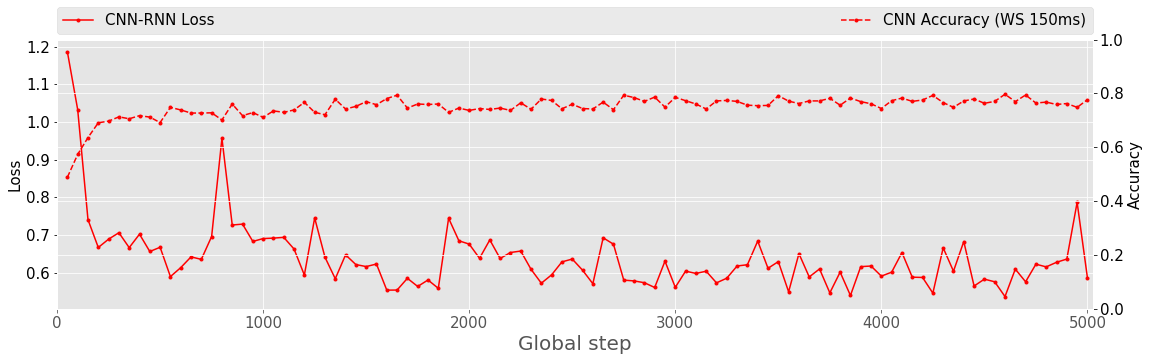

In [4]:

fig, ax1 = plt.subplots()
t = np.arange(50, 5050, 50)

loss = [1.1862776,1.033038,0.7410689,0.66726273,0.68934464,0.70641392,0.66688889,0.70253301,0.65661025,0.66780138,0.5900557,0.61378068,0.64234227,0.63575906,0.69629747,0.95696092,0.72687763,0.72921509,0.68334949,0.69088626,0.69209057,0.69413042,0.66316581,0.59417421,0.7455824,0.64153808,0.58432215,0.64773548,0.62191164,0.61667407,0.6233564,0.55416,0.55434632,0.58552247,0.56388742,0.5810743,0.55895233,0.74482441,0.68498027,0.6762324,0.63863003,0.6873576,0.63805938,0.65392572,0.65778607,0.60939491,0.57257128,0.59479296,0.6291129,0.63658088,0.60708791,0.57118917,0.69295323,0.67599761,0.58067161,0.57859486,0.57383466,0.56114352,0.63102716,0.5616101,0.60446924,0.5985024,0.60425651,0.57344842,0.58583641,0.61819279,0.62149608,0.68423063,0.61211002,0.62976313,0.54973656,0.65094846,0.58913213,0.61032391,0.5469175,0.60190207,0.53993642,0.61646867,0.61808133,0.59128165,0.60178828,0.65367115,0.58852464,0.58776259,0.5461961,0.66634315,0.60434455,0.68307662,0.5650835,0.58325601,0.5762946,0.53709823,0.60986161,0.57629144,0.62298894,0.61580282,0.62800288,0.63657808,0.78696209,0.5870626]
CNNRNN_loss, = ax1.plot(t, loss, 'r.-', label='CNN-RNN Loss')
ax1.set_xlabel('Global step', fontsize=20)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Loss', color='k', fontsize=15)
ax1.tick_params('y', colors='k')
ax1.tick_params(axis='both', labelsize=15)

accu = [0.48851591,0.57332158,0.63604242,0.69081271,0.69699645,0.71289754,0.7058304,0.71731448,0.71201414,0.69169611,0.7482332,0.73851591,0.72703183,0.72703183,0.72791517,0.70141345,0.76060069,0.71731448,0.72879857,0.71113074,0.73498231,0.72968197,0.73851591,0.76678443,0.72968197,0.72084808,0.77826858,0.74204946,0.7517668,0.76943463,0.75795054,0.78091872,0.7932862,0.74558306,0.76060069,0.75883394,0.76060069,0.72968197,0.74558306,0.73674911,0.74381626,0.74028271,0.74558306,0.73674911,0.76501769,0.74116606,0.77915192,0.77385157,0.74293286,0.75971729,0.74381626,0.74204946,0.76766783,0.73939931,0.7932862,0.78445232,0.77031803,0.78621906,0.7491166,0.78533566,0.77296817,0.76060069,0.74204946,0.77208483,0.77385157,0.77031803,0.75618374,0.75441694,0.75530034,0.79151946,0.77120143,0.76236749,0.77208483,0.77208483,0.78180212,0.75618374,0.78268552,0.76943463,0.76148409,0.74381626,0.77296817,0.78268552,0.77031803,0.77561837,0.7924028,0.76590109,0.7482332,0.77208483,0.77915192,0.76325089,0.77031803,0.79681981,0.76943463,0.7941696,0.76413429,0.76766783,0.75883394,0.76236749,0.7482332,0.77650177]
ax2 = ax1.twinx()
CNNRNN_accu, = ax2.plot(t, accu, 'r.--', label='CNN Accuracy (WS 150ms)')
ax2.set_ylim(0, 1.0)
ax2.set_ylabel('Accuracy', color='k', fontsize=15)
ax2.tick_params('y', colors='k')
ax2.tick_params(axis='both', labelsize=15)

plt.xlim([0, t[-1] + 25])

# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0., handles=[CNN_loss, CNN_accu])

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., 
           handles=[CNNRNN_loss, CNNRNN_accu],
           fontsize=15)

fig.tight_layout()

f = plt.gcf()
f.set_figwidth(20.0)
f.set_figheight(5.0)

plt.show()



In [8]:
max([0.48851591,0.57332158,0.63604242,0.69081271,0.69699645,0.71289754,0.7058304,0.71731448,0.71201414,0.69169611,0.7482332,0.73851591,0.72703183,0.72703183,0.72791517,0.70141345,0.76060069,0.71731448,0.72879857,0.71113074,0.73498231,0.72968197,0.73851591,0.76678443,0.72968197,0.72084808,0.77826858,0.74204946,0.7517668,0.76943463,0.75795054,0.78091872,0.7932862,0.74558306,0.76060069,0.75883394,0.76060069,0.72968197,0.74558306,0.73674911,0.74381626,0.74028271,0.74558306,0.73674911,0.76501769,0.74116606,0.77915192,0.77385157,0.74293286,0.75971729,0.74381626,0.74204946,0.76766783,0.73939931,0.7932862,0.78445232,0.77031803,0.78621906,0.7491166,0.78533566,0.77296817,0.76060069,0.74204946,0.77208483,0.77385157,0.77031803,0.75618374,0.75441694,0.75530034,0.79151946,0.77120143,0.76236749,0.77208483,0.77208483,0.78180212,0.75618374,0.78268552,0.76943463,0.76148409,0.74381626,0.77296817,0.78268552,0.77031803,0.77561837,0.7924028,0.76590109,0.7482332,0.77208483,0.77915192,0.76325089,0.77031803,0.79681981,0.76943463,0.7941696,0.76413429,0.76766783,0.75883394,0.76236749,0.7482332,0.77650177])

0.79681981